## import base input targetlist

In [2]:
# inputs

# targetlist fname
targetlist_fname = '/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/week 5/targetlist.csv'

# Retrieval folder
retrieval_folder = "./retrievals/Tier2"

# forwards folder
forwards_folder = "./forwards/ArielInstrumentTier2"

# models

comp_folders = "/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/week 5/20250322_ArielTargetProfileData_ChangedPnames"

pt_folders = "/home/ariel/lorenzo.mugnai/USER_DATA/Alfnoor2/20250226 - NAOJ/week 5/20250322_ArielTargetProfileData_ChangedPnames"

# out tab
out_tab_fname = 'Tier2_v2_data_analyzed.csv'



In [3]:
import sys
import os

# Add the current notebook's directory to the Python path
sys.path.append(os.getcwd())

# Now import the function
from inspector import Inspector

# Create an instance of the Inspector class
inspector = Inspector(targetlist_fname, retrieval_folder, forwards_folder)

print(inspector.out_targetlist.keys())



['Star Name', 'Star Mass [Ms]', 'Spectral Type', 'Star Temperature [K]', 'Star Radius [Rs]', 'Star Distance [pc]', 'Star K Mag', 'Star V Mag', 'Star Metallicity', 'Star Age [Gyr]', 'Star RA', 'Star Dec', 'Planet Name', 'Planet Period [days]', 'Planet Temperature [K]', 'Planet Semi-major Axis [m]', 'Planet Radius [Re]', 'Planet Albedo', 'Planet Mass [Me]', 'Molecular Weight', 'Transit Duration [s]', 'Impact Parameter', 'Heat Redistribution Factor', 'Inclination', 'Eccentricity', 'Transit Mid Time', 'Tier', 'Best Method', 'Time [s]', 'Chemistry filename', 'Pressure-Temperature filename', 'COratio', 'OHratio', 'HeHratio', 'Migration Efficiency [Fiducial = 0, Efficient = 1]', 'Redox [Reduced = 0, Oxidized = 1]', 'Accreted Ice/Rock ratio', 'RemainingAtm/InitialAtm', 'InitialAtm/Rock']


## Load retrievals

In [4]:
inspector.load_retrievals()

loading retrieval data


100%|██████████| 152/152 [00:00<00:00, 314.26it/s]


-> File not found: K2-138fFiduR
-> File not found: Kepler-109cFiduR
found 150 valid planets


100%|██████████| 150/150 [00:01<00:00, 149.55it/s]


In [5]:
inspector.missing_planets()

missing_planets = inspector.create_missing_planets_table()
print(missing_planets)
from astropy.io import ascii
ascii.write(missing_planets, "missing_planets_ret.csv", format='csv', overwrite=True)

Missing planets: 2
[101, 103]
  Planet Name   
----------------
    K2-138fFiduR
Kepler-109cFiduR
Star Name  Star Mass [Ms] ... RemainingAtm/InitialAtm InitialAtm/Rock
---------- -------------- ... ----------------------- ---------------
    K2-138           0.94 ...                0.614373        0.032903
Kepler-109           1.01 ...                0.518959        0.130353


## load Ariel's data

In [6]:
inspector.load_ariel_data()

loading ariel data


100%|██████████| 150/150 [00:00<00:00, 1044.88it/s]


## load profile data

In [7]:
inspector.laod_profiles(comp_folders, pt_folders)

loading profiles


100%|██████████| 150/150 [00:00<00:00, 215.35it/s]


## Compute metallicities

In [8]:
inspector.compute_elemental_ratios()
inspector.compute_profile_ratios()

computing elemental ratios


100%|██████████| 150/150 [00:00<00:00, 1967.64it/s]


computing profile ratios


100%|██████████| 150/150 [00:00<00:00, 3015.84it/s]


## saving data

In [9]:
inspector.save_table(out_tab_fname)

Table saved to Tier2_v2_data_analyzed.csv


# Let's do some plotting now

/tmp/ipykernel_2940391/891722408.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


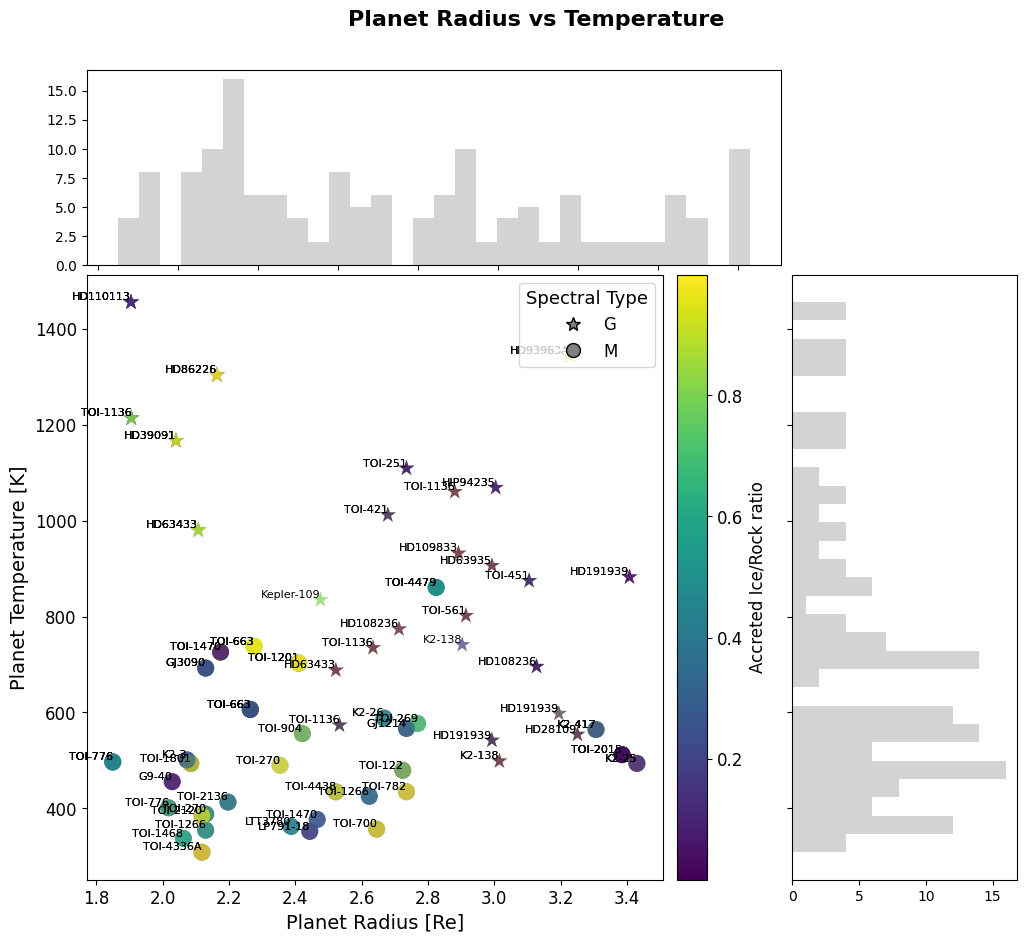

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Extract data from the inspector's output table
x = inspector.out_targetlist['Planet Radius [Re]']
y = inspector.out_targetlist['Planet Temperature [K]']
spectral = inspector.out_targetlist['Spectral Type']
ice_rock_ratio = inspector.out_targetlist['Accreted Ice/Rock ratio']

# Remove NaNs e stringhe vuote e garantire che la colonna ratio sia valida
mask = (~np.isnan(x)) & (~np.isnan(y)) & (spectral != '') & (~np.isnan(ice_rock_ratio))
x = x[mask]
y = y[mask]
spectral = spectral[mask]
ice_rock_ratio = ice_rock_ratio[mask]

# Define marker mapping based on spectral type
marker_map = {
    'M': 'o',  # circle for type M
    'G': '*',  # square for type G
}
# For spectral types not in marker_map, we assign a default marker (e.g. triangle)
# (Not strictly necessary se si hanno solo "M" e "G")
markers = np.array([marker_map[stype] if stype in marker_map else '^' for stype in spectral])

# Set up figure and grid layout
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(4, 4, hspace=0.05, wspace=0.05)

ax_main = fig.add_subplot(gs[1:, :-1])
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_main)
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_main)

# Define colormap for the "Accreted Ice/Rock ratio"
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=np.nanmin(ice_rock_ratio), vmax=np.nanmax(ice_rock_ratio))

# === Scatter plot ===
# Plot points per spectral type to differenciare le popolazioni tramite forma
unique_types = np.unique(spectral)
for stype in unique_types:
    group_mask = (spectral == stype)
    ax_main.scatter(x[group_mask], y[group_mask], 
                    c=ice_rock_ratio[group_mask], cmap=cmap, norm=norm,
                    marker=marker_map[stype] if stype in marker_map else '^', 
                    edgecolors='none', linewidths=0.5, alpha=0.7, label=stype, s=150)

ax_main.set_xlabel("Planet Radius [Re]", fontsize=14)
ax_main.set_ylabel("Planet Temperature [K]", fontsize=14)
ax_main.tick_params(axis='both', labelsize=12)


# Annotate planet names with a larger font size
star_names = inspector.out_targetlist['Star Name'][mask].astype(str)
for xi, yi, name in zip(x, y, star_names):
    ax_main.annotate(name, (xi, yi), fontsize=8, ha='right', va='bottom')

# === Top histogram ===
ax_xhist.hist(x, bins=30, color="lightgrey")
ax_xhist.tick_params(axis='x', labelbottom=False)
ax_xhist.tick_params(axis='y', labelsize=10)

# === Right histogram ===
ax_yhist.hist(y, bins=30, orientation="horizontal", color="lightgrey")
ax_yhist.tick_params(axis='y', labelleft=False)
ax_yhist.tick_params(axis='x', labelsize=10)

# === Legend based on spectral type (marker shape) ===
handles = [plt.Line2D([0], [0], marker=marker_map[t] if t in marker_map else '^', color='w', label=t,
                      markerfacecolor='gray', markersize=10, markeredgecolor='k')
           for t in unique_types]
ax_main.legend(handles=handles, title="Spectral Type", fontsize=12, title_fontsize=13, loc='upper right')

# === Add a colourbar based on the 'Accreted Ice/Rock ratio' ===
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax_main, pad=0.02)
cbar.set_label("Accreted Ice/Rock ratio", fontsize=12)

# === Title ===
fig.suptitle("Planet Radius vs Temperature", 
             fontsize=16, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


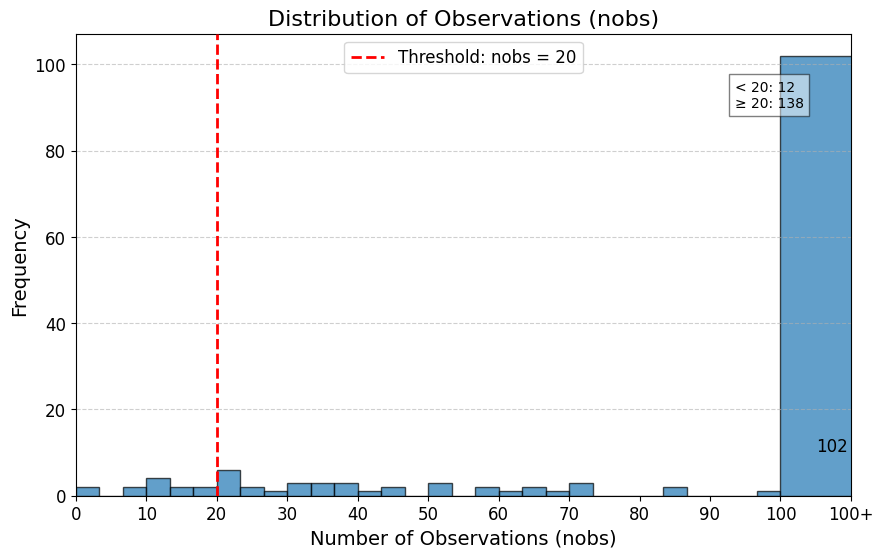

In [11]:
inspector.plot_nobs()

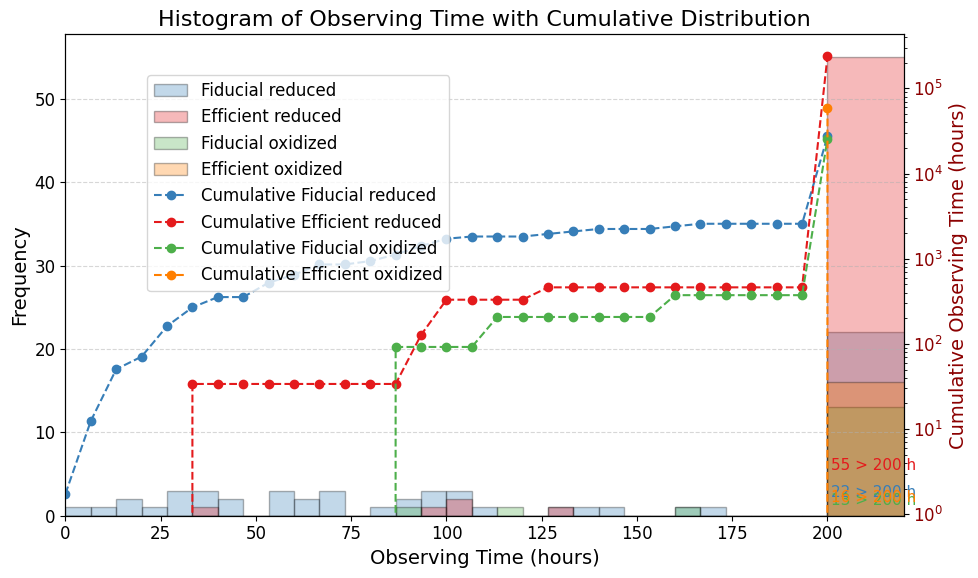

In [12]:
# inspector.plot_obs_time(selection = np.where(inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0))

inspector.plot_obs_time(
    selections=[np.where((inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0) & (inspector.out_targetlist["Redox [Reduced = 0, Oxidized = 1]"]==0)),
                np.where((inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1) & (inspector.out_targetlist["Redox [Reduced = 0, Oxidized = 1]"]==0)),
                np.where((inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0) & (inspector.out_targetlist["Redox [Reduced = 0, Oxidized = 1]"]==1)),
                np.where((inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1) & (inspector.out_targetlist["Redox [Reduced = 0, Oxidized = 1]"]==1))],
    labels=["Fiducial reduced", "Efficient reduced", "Fiducial oxidized", "Efficient oxidized"],
    colours=["#377eb8", "#e41a1c", "#4daf4a", "#ff7f00"],
)

In [13]:
obs = inspector.out_targetlist["obs_time"].data
obs.sort()
cum = np.cumsum(obs)
print(obs, cum)
idx = np.argmin(np.abs(cum - 1000))
print(idx)

[1.73932000e+00 1.07200000e+01 1.86720000e+01 1.93300000e+01
 2.05730000e+01 2.82200000e+01 2.95300000e+01 3.31360000e+01
 3.39167400e+01 3.44100000e+01 3.51180000e+01 3.75000000e+01
 4.25100000e+01 4.36800000e+01 5.54400000e+01 5.54400000e+01
 5.75640000e+01 6.20770000e+01 6.40500000e+01 6.68704000e+01
 6.91600000e+01 7.17600000e+01 8.20000000e+01 8.82288000e+01
 9.22320000e+01 9.31500000e+01 9.35760000e+01 9.45060000e+01
 9.57260000e+01 9.98400000e+01 1.00362000e+02 1.01640000e+02
 1.01660000e+02 1.02865000e+02 1.04338000e+02 1.06800000e+02
 1.15167000e+02 1.31200000e+02 1.32076000e+02 1.37428000e+02
 1.42848000e+02 1.66500000e+02 1.66600000e+02 1.71764000e+02
 2.03000000e+02 2.06641111e+02 2.08640000e+02 2.20670400e+02
 2.20709300e+02 2.40312000e+02 2.50470000e+02 2.75500000e+02
 3.03900000e+02 3.12000000e+02 3.48432000e+02 3.57399000e+02
 3.83460000e+02 4.03845000e+02 4.23640000e+02 5.09040000e+02
 5.15570000e+02 5.24560000e+02 5.25280000e+02 5.34750000e+02
 5.61960000e+02 5.619600

## validate retrieval

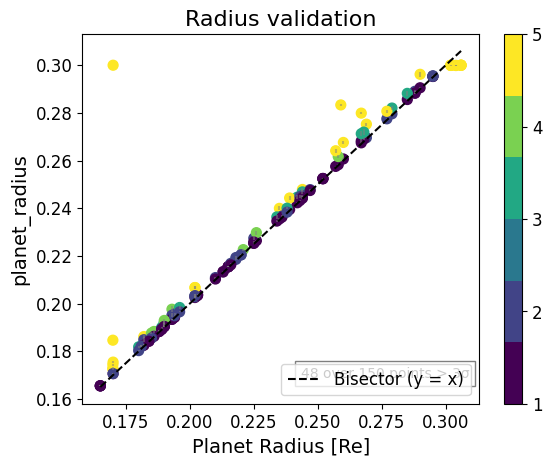

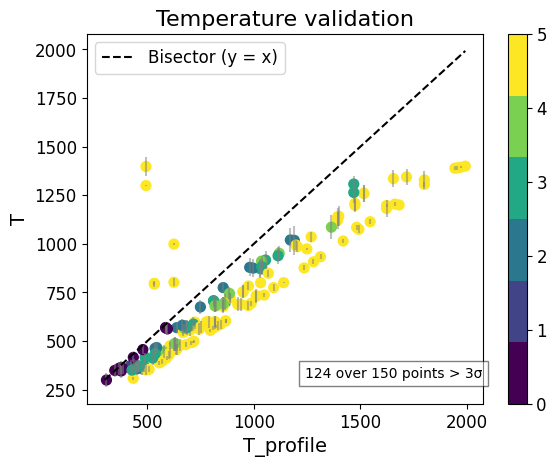

In [14]:
import astropy.units as u
inspector.plot_comparison('Planet Radius [Re]', 'planet_radius', 'planet_radius_sigma_p', 'planet_radius_sigma_m', title="Radius validation", conversion_factor=u.R_earth.to(u.R_jup))

inspector.plot_comparison('T_profile', 'T', 'T_sigma_p', 'T_sigma_m', title="Temperature validation")


In [15]:
#sorting the table

inspector.out_targetlist.sort(['Redox [Reduced = 0, Oxidized = 1]',"Migration Efficiency [Fiducial = 0, Efficient = 1]"])

selections=[list(np.where((inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0) & (inspector.out_targetlist["Redox [Reduced = 0, Oxidized = 1]"]==0))[0]),
            list(np.where((inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1) & (inspector.out_targetlist["Redox [Reduced = 0, Oxidized = 1]"]==0))[0]),
            list(np.where((inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0) & (inspector.out_targetlist["Redox [Reduced = 0, Oxidized = 1]"]==1))[0]),
            list(np.where((inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1) & (inspector.out_targetlist["Redox [Reduced = 0, Oxidized = 1]"]==1))[0])]

print(selections)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57], [58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117], [118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133], [134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]]


## notes
- under estimation of temperature might be expected. 
- No cstrong correlation with failing water fit

/export/NAS/ariel/data/lorenzo.mugnai/Alfnoor2/20250226 - NAOJ/week 5/inspector.py:893: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit the colourbar


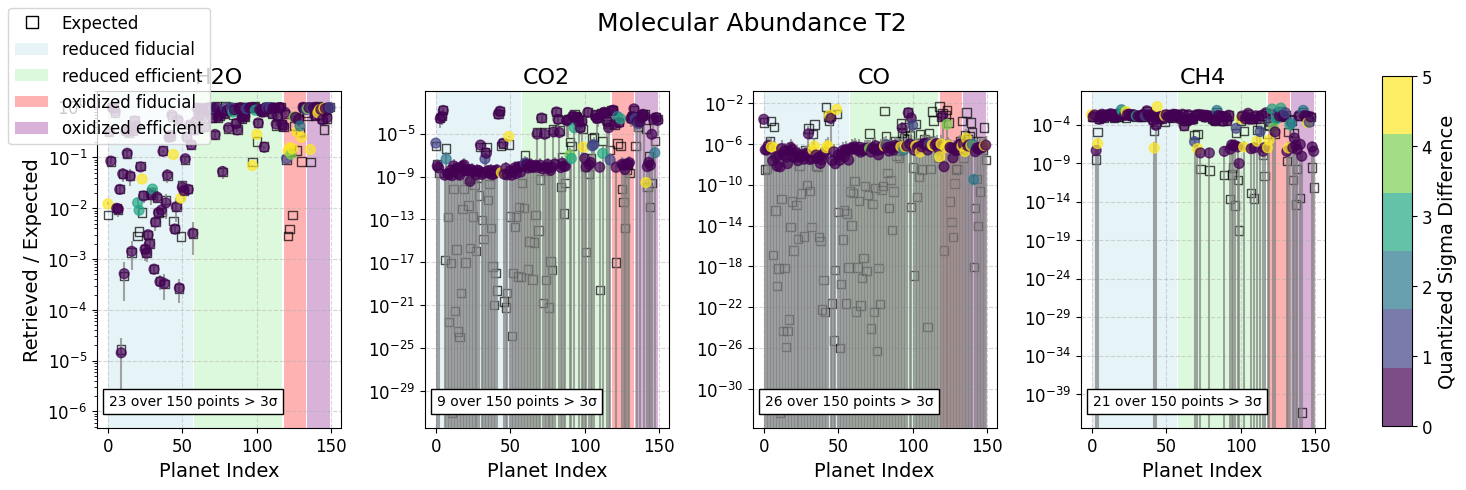

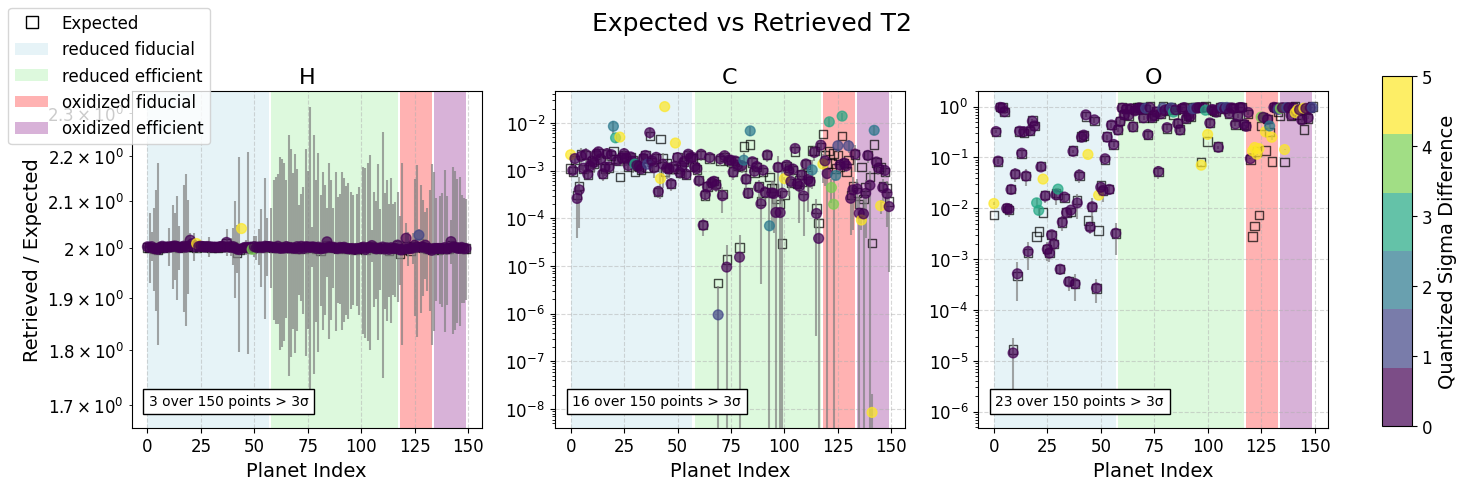

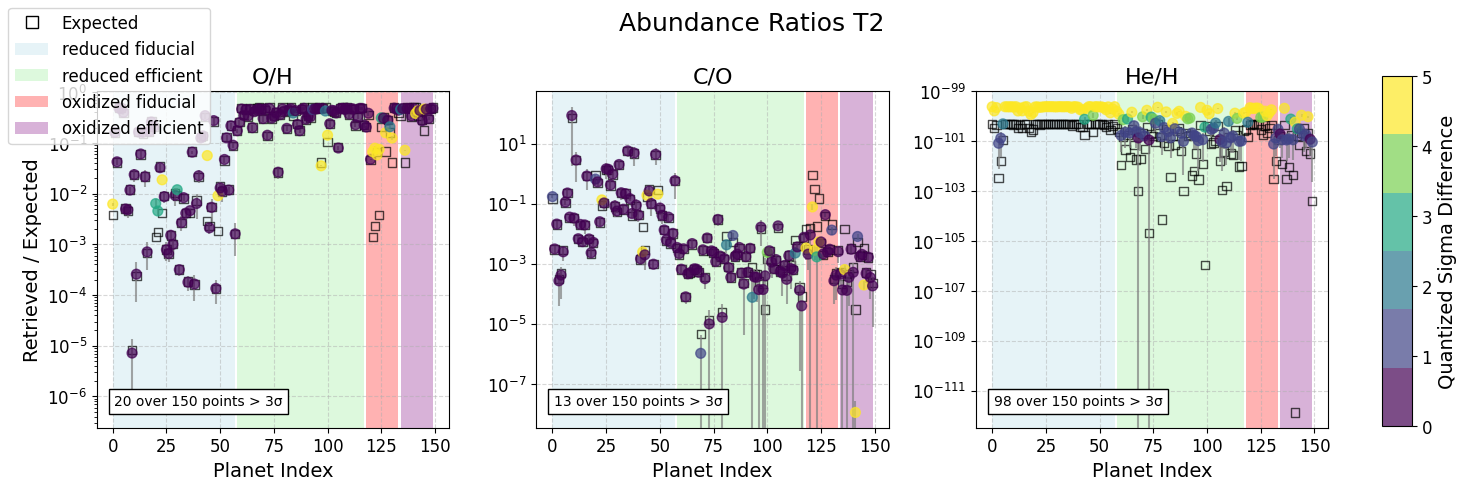

In [16]:
# Example of the background_regions parameter
background_regions = [
    {"start": selections[0][0], "end": selections[0][-1], "color": "lightblue", "alpha": 0.3, "label": "reduced fiducial"},
    {"start": selections[1][0], "end": selections[1][-1], "color": "lightgreen", "alpha": 0.3, "label": "reduced efficient"},
    {"start": selections[2][0], "end": selections[2][-1], "color": "red", "alpha": 0.3, "label": "oxidized fiducial"},
    {"start": selections[3][0], "end": selections[3][-1], "color": "purple", "alpha": 0.3, "label": "oxidized efficient"},
]


inspector.plot_comparison_panels(keys=["H2O", "CO2", "CO", "CH4"], title="Molecular Abundance T2", alpha=0.7, background_regions=background_regions)

inspector.plot_comparison_panels(keys=["H", "C", "O"], title="Expected vs Retrieved T2", alpha=0.7, background_regions=background_regions)

inspector.plot_comparison_panels(keys=["O/H", "C/O", "He/H"], title="Abundance Ratios T2", alpha=0.7, background_regions=background_regions)



## notes

- water is failing because conditions are changed: we have priors on the water abundance up to 0.7, but inputs go up to 1.0. This is why the retrieval is failing. We need to fix this. 
- most of the O comes from water, so we need to fix this.


/export/NAS/ariel/data/lorenzo.mugnai/Alfnoor2/20250226 - NAOJ/week 5/inspector.py:1015: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax_scatter.scatter(
/export/NAS/ariel/data/lorenzo.mugnai/Alfnoor2/20250226 - NAOJ/week 5/inspector.py:1015: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(


Text(0.5, 0.98, 'Input values')

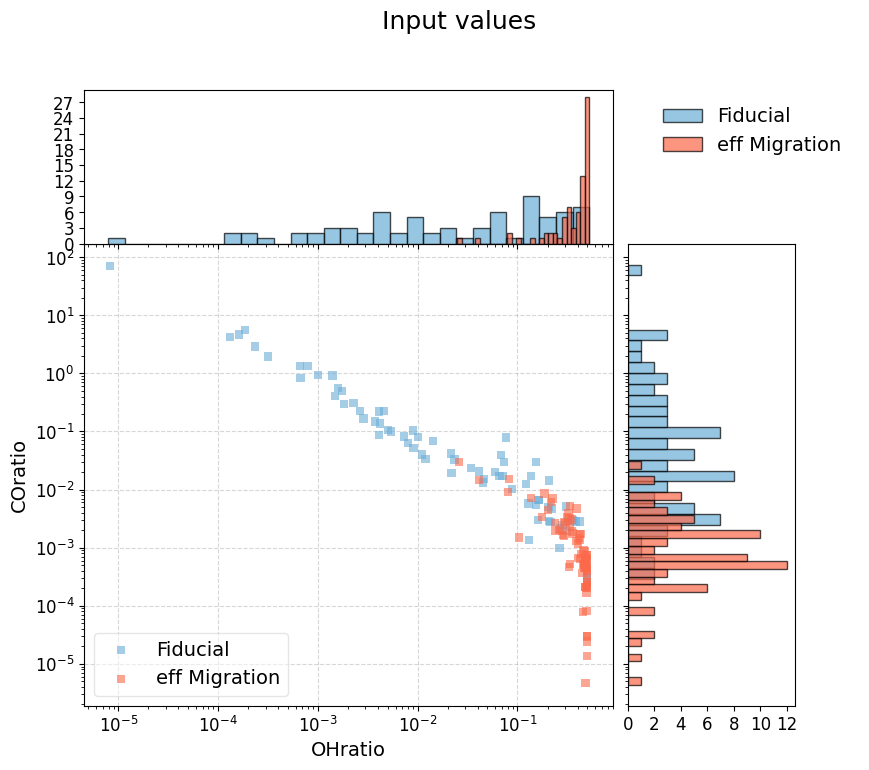

In [17]:


fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm, = inspector.plot_scatter_with_histograms(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0, 
    x_key= "OHratio", y_key="COratio",
    label="Fiducial", marker="s", cmap="Blues", hist_color="blue"
)

inspector.plot_scatter_with_histograms(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1, 
    x_key="OHratio", y_key="COratio",
    label="eff Migration", marker="s", cmap="Reds", hist_color="red",
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig, global_norm=global_norm
)
fig.suptitle("Input values")

Text(0.5, 0.98, 'Retrievals compared')

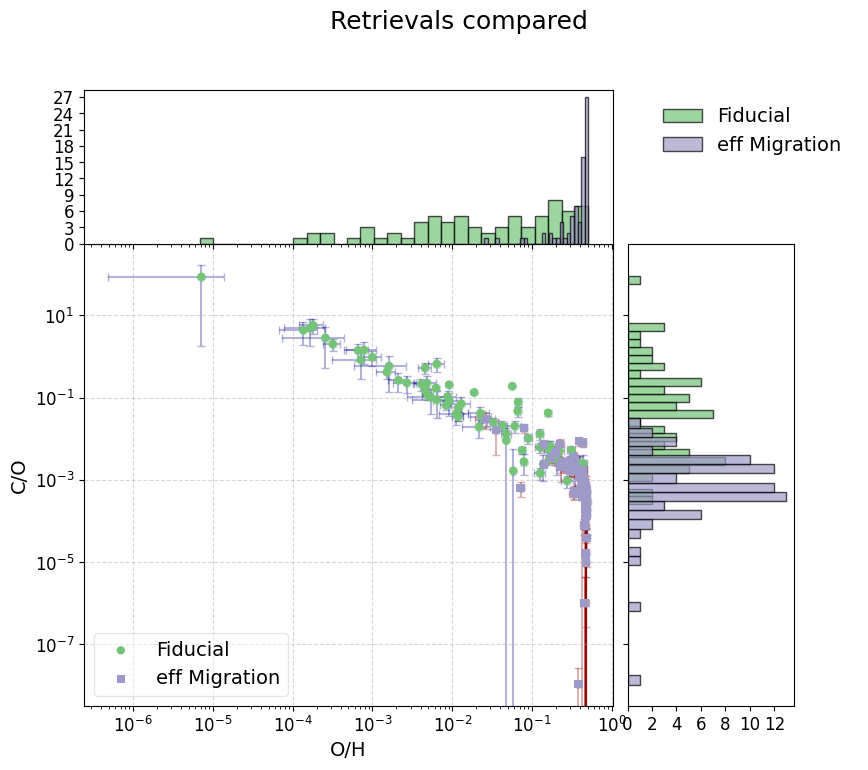

In [18]:

fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = inspector.plot_scatter_with_histograms(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0, 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    # color_key="He/H", 
    label="Fiducial", marker="o", cmap="Greens", hist_color="green", alpha=1,
    err_color="darkblue", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
)

inspector.plot_scatter_with_histograms(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1, 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    # color_key="He/H", 
    label="eff Migration", marker="s", cmap="Purples", hist_color="purple", alpha=1,
    err_color="darkred", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, global_norm=global_norm, fig=fig)

fig.suptitle("Retrievals compared")

/export/NAS/ariel/data/lorenzo.mugnai/Alfnoor2/20250226 - NAOJ/week 5/inspector.py:1010: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax_scatter.scatter(


(<Figure size 1000x800 with 4 Axes>,
 <Axes: title={'center': 'Scatter Plot of O/H vs C/O'}, xlabel='O/H', ylabel='C/O'>,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 None)

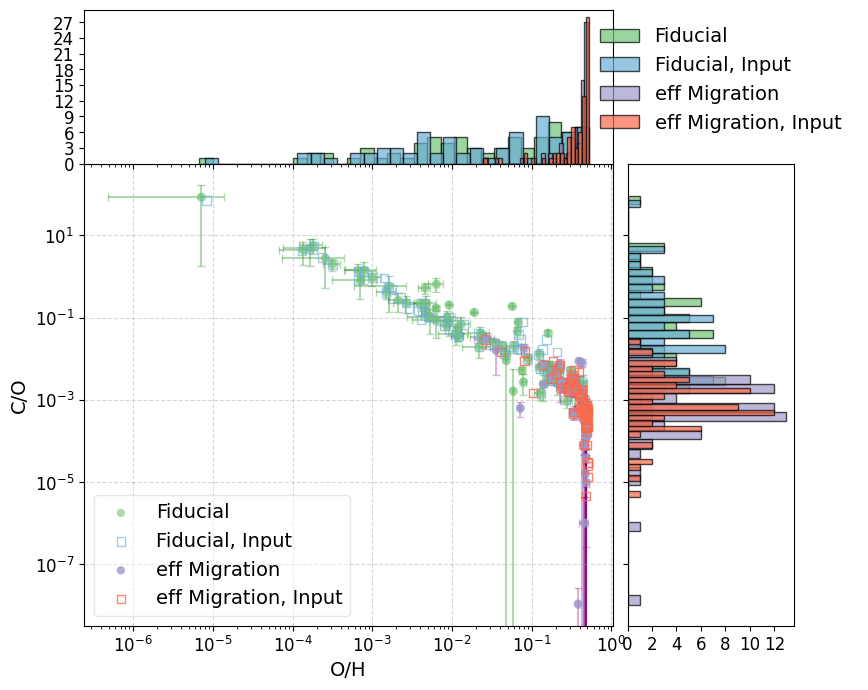

In [19]:
fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = inspector.plot_scatter_with_histograms(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0, 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    label="Fiducial", marker="o", cmap="Greens", hist_color="green",
    err_color="green", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
)

inspector.plot_scatter_with_histograms(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0, 
    x_key="OHratio", y_key="COratio", 
    label="Fiducial, Input", marker="s", cmap="Blues", hist_color="orange", contour_only=True,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)


inspector.plot_scatter_with_histograms(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1, 
    x_key="O/H", y_key="C/O", 
    x_err_key="O/H_sigma", y_err_key="C/O_sigma", 
    label="eff Migration", marker="o", cmap="Purples", hist_color="purple", alpha=0.8,
    err_color="purple", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)


inspector.plot_scatter_with_histograms(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1, 
    x_key="OHratio", y_key="COratio", 
    label="eff Migration, Input", marker="s", cmap="Reds", hist_color="red", alpha=0.8, contour_only=True,
    ax_scatter=ax_s, ax_hist_x=ax_hx, ax_hist_y=ax_hy, ax_legend=ax_leg, fig=fig)



/export/NAS/ariel/data/lorenzo.mugnai/Alfnoor2/20250226 - NAOJ/week 5/inspector.py:1200: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  data_scatter = ax_scatter.scatter(
/export/NAS/ariel/data/lorenzo.mugnai/Alfnoor2/20250226 - NAOJ/week 5/inspector.py:1200: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  data_scatter = ax_scatter.scatter(


Text(0.5, 0.98, 'eff Migration')

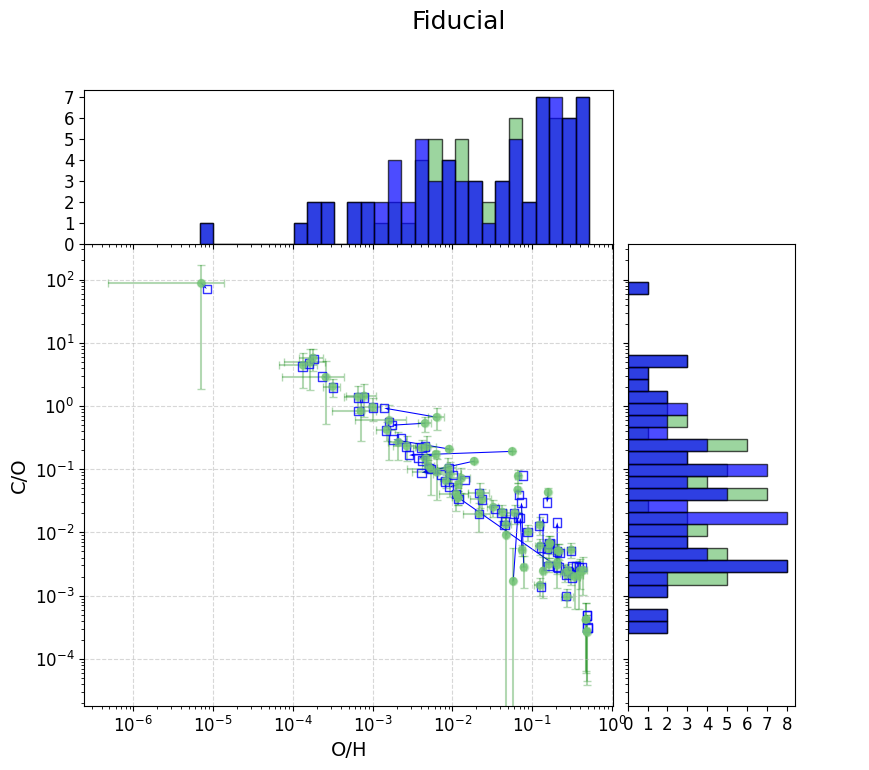

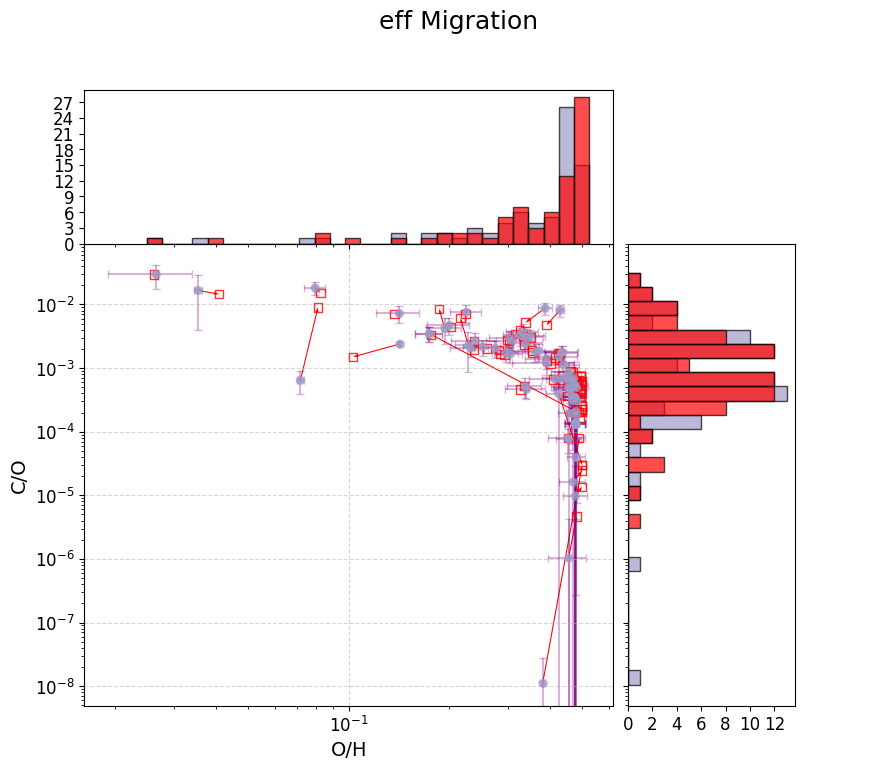

In [20]:
fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = inspector.plot_scatter_with_histograms_compared_with_expectation(
        selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==0, 
        color_key=None, expect_color="b",
        label="Fiducial", marker="o", cmap="Greens", hist_color="green",  alpha=0.8,
        err_color="green", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3
        )
fig.suptitle("Fiducial")

fig, ax_s, ax_hx, ax_hy, ax_leg, global_norm = inspector.plot_scatter_with_histograms_compared_with_expectation(
    selection = inspector.out_targetlist["Migration Efficiency [Fiducial = 0, Efficient = 1]"]==1, 
    label="eff Migration", marker="o", cmap="Purples", hist_color="purple", alpha=0.8, expect_color="r",
    err_color="purple", elinewidth=1.5, capsize=3, capthick=1, errorevery=1, err_alpha=0.3,
    )
fig.suptitle("eff Migration")


In [21]:
from astropy.table import Table
import numpy as np
# print(inspector.out_targetlist["Planet Name"])

planet_names = inspector.out_targetlist["Planet Name"].astype(str)
# print(planet_names)
pls = set([p.replace("Mig", "").replace("Fidu", "") for p in planet_names])
pls = list(pls)
pls.sort()
print(len(pls))
new_tab = Table()
new_tab["Planet Name"] =list(pls)

dist_OH = []
dist_CO = []
dist_HeH = []
stellar = []

def dist(key):
    return np.abs(inspector.out_targetlist[key][planet_names==f"{p}Mig"].data[0] - inspector.out_targetlist[key][planet_names==f"{p}Fidu"].data[0])
def dist_err(key):
    return inspector.out_targetlist[key+"_sigma"][planet_names==f"{p}Mig"].data[0]**2 + inspector.out_targetlist[key+"_sigma"][planet_names==f"{p}Fidu"].data[0]**2

for p in pls:
    try:
        dist_OH.append(dist("O/H")/dist_err("O/H")**0.5)
        dist_CO.append(dist("C/O")/dist_err("C/O")**0.5)
        dist_HeH.append(dist("He/H")/dist_err("He/H")**0.5)
        stellar.append(inspector.out_targetlist["Spectral Type"][planet_names==f"{p}Mig"].data[0])

    except IndexError:
        dist_OH.append(None)
        dist_CO.append(None)
        dist_HeH.append(None)
        stellar.append(None)



new_tab["O/H"] = dist_OH
new_tab["C/O"] = dist_CO
new_tab["He/H"] = dist_HeH      
new_tab["Spectral Type"] = stellar  

mask = np.array([
    (oh is not None) and (co is not None) and (heh is not None)
    for oh, co, heh in zip(new_tab["O/H"], new_tab["C/O"], new_tab["He/H"])
])
new_tab = new_tab[mask]


75


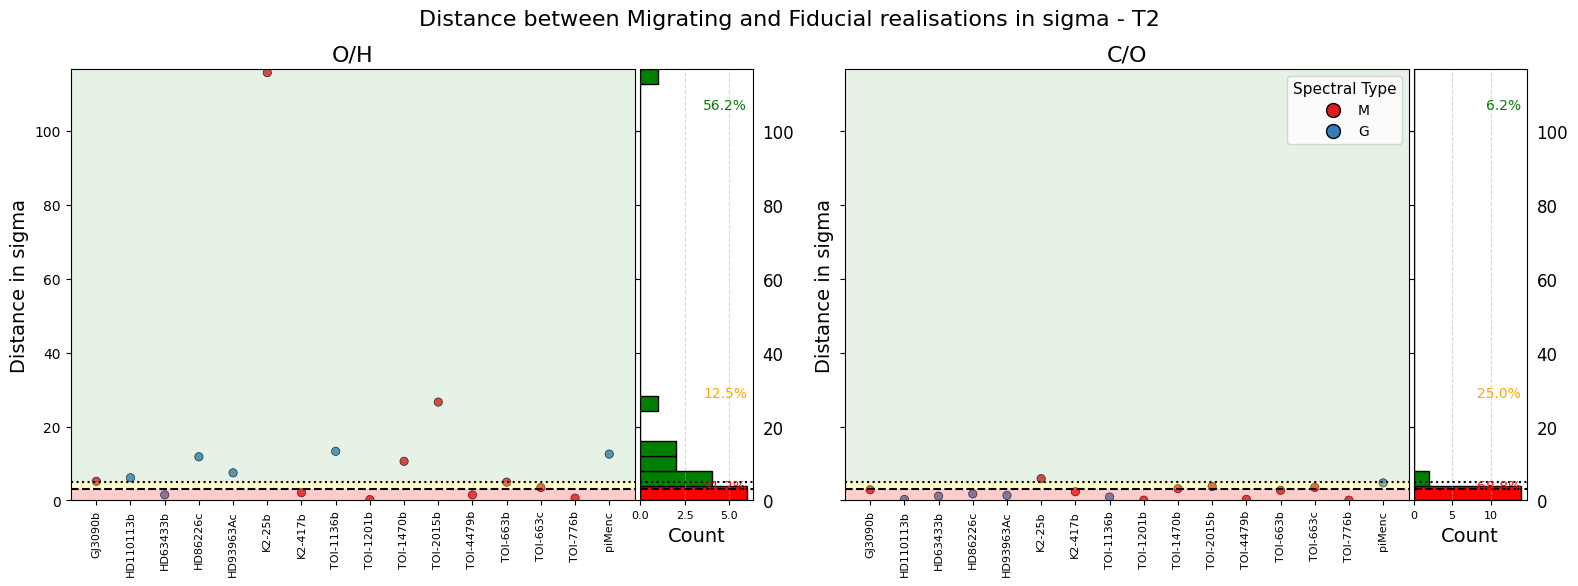

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Extract and clean data
oh_data = np.array(new_tab["O/H"], dtype=float)
co_data = np.array(new_tab["C/O"], dtype=float)
planet_names = np.array(new_tab["Planet Name"])
spectral_types = np.array(new_tab["Spectral Type"])

# Clean O/H
valid_oh = ~np.isnan(oh_data) & (spectral_types != '')
oh_data = oh_data[valid_oh]
planet_names_oh = planet_names[valid_oh]
spectral_oh = spectral_types[valid_oh]

# Clean C/O
valid_co = ~np.isnan(co_data) & (spectral_types != '')
co_data = co_data[valid_co]
planet_names_co = planet_names[valid_co]
spectral_co = spectral_types[valid_co]

# Colour map
color_map = {'M': '#e41a1c', 'G': '#377eb8'}
colours_oh = [color_map.get(s, 'grey') for s in spectral_oh]
colours_co = [color_map.get(s, 'grey') for s in spectral_co]

# Shared y range
ymin = 0
ymax = max(np.nanmax(oh_data), np.nanmax(co_data)) + 1

# Histogram bins
bins = np.linspace(ymin, ymax, 30)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

def colour_for_bin(c):
    if c < 3:
        return 'red'
    elif c < 5:
        return 'yellow'
    else:
        return 'green'

def get_region_percentages(data):
    total = len(data)
    low = np.sum(data < 3)
    mid = np.sum((data >= 3) & (data < 5))
    high = np.sum(data >= 5)
    return {
        "<3σ": 100 * low / total,
        "3–5σ": 100 * mid / total,
        ">5σ": 100 * high / total
    }

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# General plotting function with colours
def plot_panel(ax, data, names, colours, title):
    divider = make_axes_locatable(ax)
    ax_hist = divider.append_axes("right", size="20%", pad=0.05, sharey=ax)

    x = np.arange(len(data))
    ax.scatter(x, data, c=colours, alpha=0.8, edgecolors='k', linewidths=0.5)
    ax.set_title(title)
    ax.set_ylabel("Distance in sigma")
    ax.set_ylim(ymin, ymax)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=90, fontsize=8)
    ax.tick_params(axis='y', labelsize=10)

    # Background regions
    ax.axhline(3, color="k", linestyle="--")
    ax.axhline(5, color="k", linestyle=":")
    ax.axhspan(0, 3, facecolor='red', alpha=0.2)
    ax.axhspan(3, 5, facecolor='yellow', alpha=0.2)
    ax.axhspan(5, ymax, facecolor='green', alpha=0.1)

    # Histogram
    hist_vals, _ = np.histogram(data, bins=bins)
    for i in range(len(hist_vals)):
        bin_val = hist_vals[i]
        bin_centre = bin_centers[i]
        colour = colour_for_bin(bin_centre)
        ax_hist.barh(bin_centre, bin_val, height=bins[1] - bins[0],
                     color=colour, edgecolor='black')

    # Add lines and percentages
    ax_hist.axhline(3, color="k", linestyle="--")
    ax_hist.axhline(5, color="k", linestyle=":")

    percentages = get_region_percentages(data)
    ax_hist.text(0.95, 0.05, f'{percentages["<3σ"]:.1f}%', transform=ax_hist.transAxes,
                 ha='right', va='top', fontsize=10, color='red')
    ax_hist.text(0.95, 0.25, f'{percentages["3–5σ"]:.1f}%', transform=ax_hist.transAxes,
                 ha='right', va='center', fontsize=10, color='orange')
    ax_hist.text(0.95, 0.9, f'{percentages[">5σ"]:.1f}%', transform=ax_hist.transAxes,
                 ha='right', va='bottom', fontsize=10, color='green')

    ax_hist.set_xlabel("Count")
    ax_hist.tick_params(axis='y', labelleft=False, labelright=True)
    ax_hist.tick_params(axis='x', labelsize=8)
    ax_hist.grid(True, axis='x', linestyle='--', alpha=0.5)

# Plot both panels with colours
plot_panel(axs[0], oh_data, planet_names_oh, colours_oh, "O/H")
plot_panel(axs[1], co_data, planet_names_co, colours_co, "C/O")

# Legend
handles = [plt.Line2D([0], [0], marker='o', color='w', label=stype,
                      markerfacecolor=col, markersize=10, markeredgecolor='k')
           for stype, col in color_map.items()]
axs[1].legend(handles=handles, title="Spectral Type", fontsize=10, title_fontsize=11, loc='upper right')

fig.suptitle("Distance between Migrating and Fiducial realisations in sigma - T2", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()
